In [2]:
import numpy as np
import numpy.linalg as la

import scipy as sp
import scipy.linalg as sla

import matplotlib.pyplot as plt

import tqdm 

import torch
import torch.nn as nn
import torch.functional as F

Given some tensor 
$$X \in \mathbb{R}^{I \times J \times K}$$ 
we define the flattened which will make all this work compatible with regular matric multiply setups
$$X \in \mathbb{R}^{I \times (JK)}$$
whose tucker decomposition is given by
$$X=  AG(C \otimes B) + E$$.

In this formulation, 
$$G \in \mathbb{R}^{D \times (EF)}$$
$$A \in \mathbb{R}^{I \times D}$$
$$B \in \mathbb{R}^{J \times E}$$
$$C \in \mathbb{R}^{K \times F}$$

which requires that we define the kronecker product $$\otimes$$ of two matrices

$$X \otimes Y = 
\begin{bmatrix} 
X_{1,1}Y & X{1,2} Y & \cdots & X_{1,N} Y\\
X_{2,1}Y & X{2,2} Y & \cdots & X_{2,N} Y\\
\vdots & \ddots & \cdots & \vdots \\
X_{N,1}Y & X{N,2} Y & \cdots & X_{N,N} Y\\
\end{bmatrix}$$

In [3]:
def npein_kron(A, B):
    return np.einsum('ij, kl->ikjl', A, B).reshape((A.shape[0] * B.shape[0], A.shape[1] * B.shape[1]))

(5, 25) (5, 25)
True


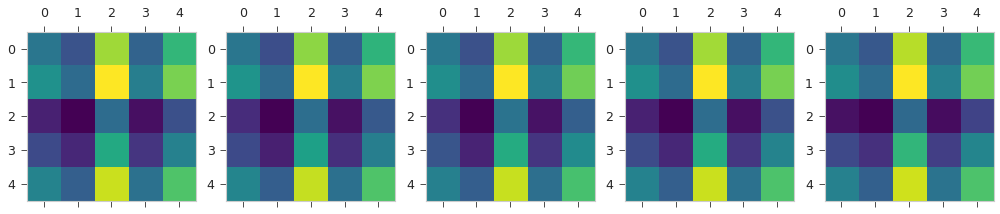

In [41]:
I, J, K = 5, 5, 5
E, F, D = 3, 3, 3

G = np.random.uniform(0, 1, size=(D, E * F))
A = np.random.uniform(0, 1, size=(I, D))
B = np.random.uniform(0, 1, size=(J, E))
C = np.random.uniform(0, 1, size=(K, F))

C_KR_B = np.kron(C, B)
X = A @ G @ C_KR_B.T

C_KR_B = npein_kron(C, B)
X_ein = A @ G @ C_KR_B.T

print(X.shape, X_ein.shape)
print(np.allclose(X, X_ein))

fig, ax = plt.subplots(1, I, figsize=(14, 3))
for i in range(I):
    ax[i].matshow(X[i].reshape((J, K)))
plt.tight_layout()
plt.show()

In [42]:
def torch_kron(A, B):
    return torch.einsum('ij, kl->ikjl', A, B).view((A.shape[0] * B.shape[0], A.shape[1] * B.shape[1]))

class DirectTucker(nn.Module):
    def __init__(self, target_dims, latent_dims, nonnegative=True):
        super(DirectTucker, self).__init__()
        self.A = nn.Parameter(torch.Tensor(target_dims[0], latent_dims[0]))
        self.B = nn.Parameter(torch.Tensor(target_dims[1], latent_dims[1]))
        self.C = nn.Parameter(torch.Tensor(target_dims[2], latent_dims[2]))

        self.G = nn.Parameter(torch.Tensor(latent_dims[0], latent_dims[1] * latent_dims[2]))
        
        nn.init.uniform_(self.A)
        nn.init.uniform_(self.B)
        nn.init.uniform_(self.C)
        nn.init.uniform_(self.G)

        if nonnegative:
            self.sm = nn.Softmax(-1)
            self.relu = nn.ReLU()
        else:
            self.sm = nn.Identity()
            self.relu = nn.Identity()
        
    def get_ABCG(self):
        return self.A.data, self.B.data, self.C.data, self.G.data
    
    def forward(self):
        C_KR_B = torch_kron(self.sm(self.C), self.sm(self.B))
        return self.sm(self.A) @ self.relu(self.G ) @ C_KR_B.transpose(-1, -2)

In [43]:
net = DirectTucker((5,5,5), (3,3,3))
optimizer = torch.optim.Adam(net.parameters(), lr=2e-1)
X_tensor = torch.FloatTensor(X)

def loss(x, x_hat):
    return ((x - x_hat)**2).sum()

net.train()
net.state_dict()

OrderedDict([('A', tensor([[0.0240, 0.4358, 0.3194],
                      [0.1508, 0.0120, 0.8388],
                      [0.1177, 0.2282, 0.9738],
                      [0.5591, 0.8835, 0.9369],
                      [0.8054, 0.1162, 0.1931]])),
             ('B', tensor([[0.0264, 0.2700, 0.8585],
                      [0.3560, 0.9520, 0.9842],
                      [0.9223, 0.5651, 0.8551],
                      [0.7075, 0.9464, 0.6907],
                      [0.0090, 0.9910, 0.2667]])),
             ('C', tensor([[0.8691, 0.1017, 0.0313],
                      [0.3996, 0.4449, 0.6733],
                      [0.1418, 0.9808, 0.0876],
                      [0.8519, 0.6574, 0.1051],
                      [0.9612, 0.8028, 0.7322]])),
             ('G',
              tensor([[0.6843, 0.5262, 0.1680, 0.9910, 0.2048, 0.9082, 0.6204, 0.7440, 0.7804],
                      [0.6850, 0.4074, 0.1694, 0.1903, 0.2984, 0.7990, 0.9672, 0.5231, 0.5817],
                      [0.4071, 0.6531, 0.5916

100%|██████████| 100/100 [00:00<00:00, 418.52it/s]


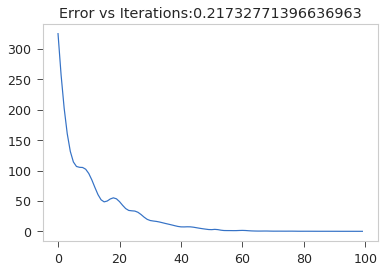

In [44]:
n_trials = 100
losses = np.zeros(n_trials)
for i in tqdm.tqdm(range(n_trials)):
    
    X_hat = net()
    cur_loss = loss(X_tensor, X_hat) 
    
    optimizer.zero_grad()
    cur_loss.backward()
    optimizer.step()
    
    losses[i] = cur_loss.item()

plt.plot(losses)
plt.title('Error vs Iterations:{}'.format(np.min(losses)))
plt.show()

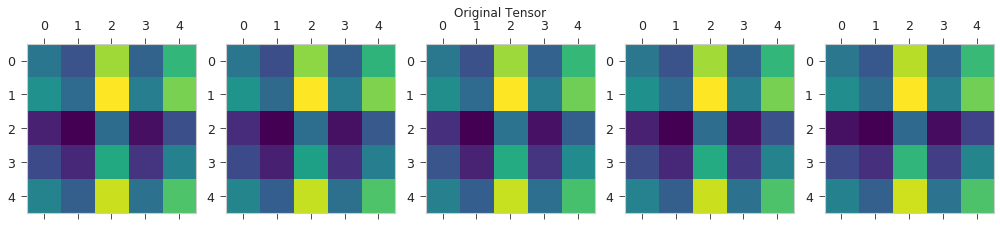

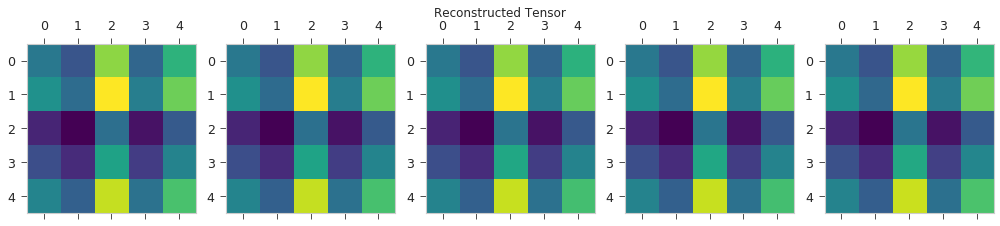

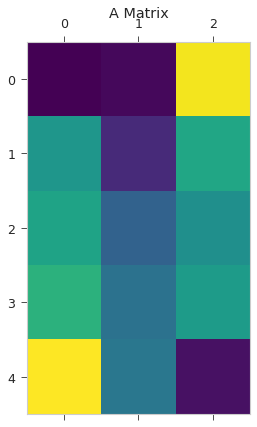

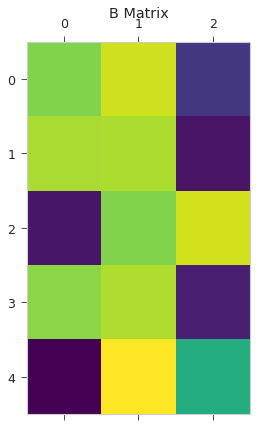

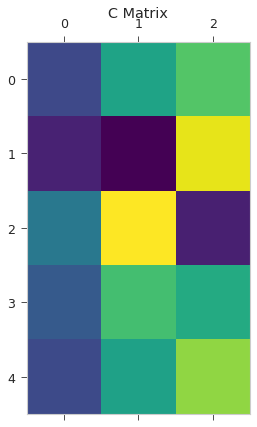

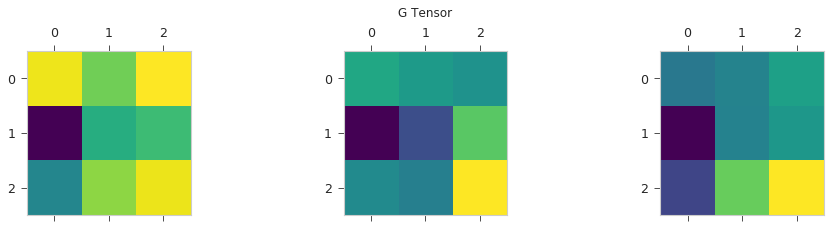

In [45]:
X_tensor = X.reshape((I, J, K))

fig, ax = plt.subplots(1, I, figsize=(14, 3))
for i in range(I):
    ax[i].matshow(X_tensor[i])
plt.suptitle('Original Tensor', y=1.04)
plt.tight_layout()
plt.show()


X_recon = net().detach().numpy().reshape((I, J, K))
A, B, C, G = net.get_ABCG()

fig, ax = plt.subplots(1, I, figsize=(14, 3))
for i in range(I):
    ax[i].matshow(X_recon[i])
plt.suptitle('Reconstructed Tensor', y=1.04)
plt.tight_layout()
plt.show()

plt.matshow(A)
plt.title('A Matrix')
plt.show()

plt.matshow(B)
plt.title('B Matrix')
plt.show()

plt.matshow(C)
plt.title('C Matrix')
plt.show()

G_tensor = G.reshape((D, E, F))
fig, ax = plt.subplots(1, D, figsize=(14, 3))
for d in range(D):
    ax[d].matshow(G_tensor[d])
plt.suptitle('G Tensor', y=1.04)
plt.tight_layout()
plt.show()

## Direct Tucker Celeb A

In [46]:
import glob2
from skimage import io

celeba_dir = './data/mini_celeba'
fnames = glob2.glob(celeba_dir + '/*.jpg')
imgs = [io.imread(fname, as_gray=True) for fname in fnames]
X = np.array(imgs)
I, J, K = X.shape

100%|██████████| 4000/4000 [04:51<00:00, 13.74it/s]


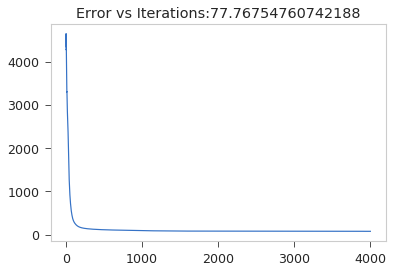

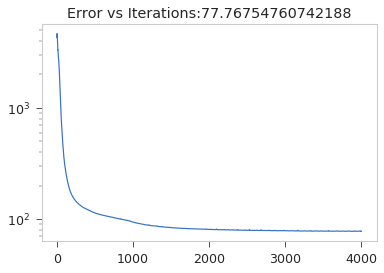

In [47]:
net = DirectTucker((I, J, K), (17,64,64))
optimizer = torch.optim.Adam(net.parameters(), lr=1e-1)

X_tensor = torch.FloatTensor(X).view(X.shape[0], -1)

def loss(x, x_hat):
    return ((x - x_hat)**2).sum()

net.train()
net.state_dict()

n_trials = 4000
losses = np.zeros(n_trials)
for i in tqdm.tqdm(range(n_trials)):
    
    X_hat = net()
    cur_loss = loss(X_tensor, X_hat) 
    
    optimizer.zero_grad()
    cur_loss.backward()
    optimizer.step()
    
    losses[i] = cur_loss.item()

plt.plot(losses)
plt.title('Error vs Iterations:{}'.format(np.min(losses)))
plt.show()

plt.semilogy(losses)
plt.title('Error vs Iterations:{}'.format(np.min(losses)))
plt.show()

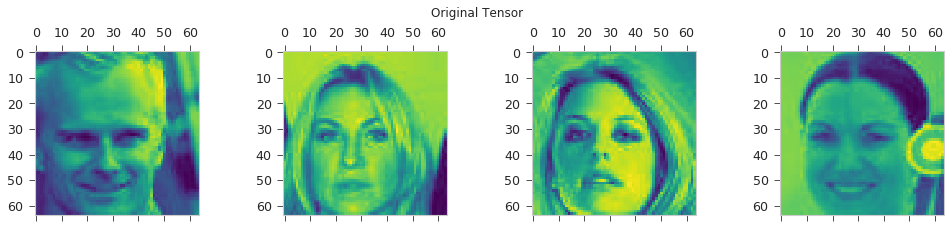

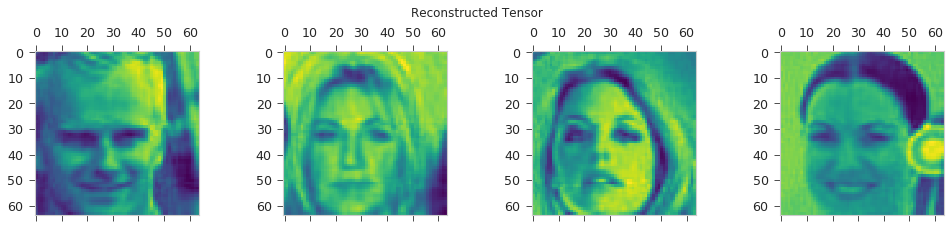

In [48]:
X_tensor = X.reshape((I, J, K))
to_plot = 4

fig, ax = plt.subplots(1, to_plot, figsize=(14, 3))
for i in range(to_plot):
    ax[i].matshow(X_tensor[i])
plt.suptitle('Original Tensor', y=1.04)
plt.tight_layout()
plt.show()


X_recon = net().detach().numpy().reshape((I, J, K))

fig, ax = plt.subplots(1, to_plot, figsize=(14, 3))
for i in range(to_plot):
    ax[i].matshow(X_recon[i])
plt.suptitle('Reconstructed Tensor', y=1.04)
plt.tight_layout()
plt.show()

## Autoencoder Tucker

In [88]:
class AutoEncoderTucker(nn.Module):
    def __init__(self, target_dims, latent_dims):
        super(AutoEncoderTucker, self).__init__()    
        B = np.random.uniform(size=(target_dims[1], latent_dims[1]))
        C = np.random.uniform(size=(target_dims[2], latent_dims[2]))
        G = np.random.uniform(size=(latent_dims[0], latent_dims[1] * latent_dims[2]))
        
        self.B = nn.Parameter(torch.Tensor(B))
        self.C = nn.Parameter(torch.Tensor(C))
        self.G = nn.Parameter(torch.Tensor(G))
        
        
        self.B_inv = nn.Parameter(torch.Tensor(np.linalg.pinv(B)))
        self.C_inv = nn.Parameter(torch.Tensor(np.linalg.pinv(C)))
        self.G_inv = nn.Parameter(torch.Tensor(np.linalg.pinv(G)))
        
        self.sm = nn.Softmax(-1)
        self.relu = nn.ReLU()

    def get_A(self, X):
        return self.encode(X)
    
    def get_BCG(self):
        return self.B.data, self.C.data, self.G.data
    
    def encode(self, X):
        X_T = X.transpose(0, 1)
        C_KR_B_INV = torch_kron(self.C_inv, self.B_inv)
        G_inv_T = self.G_inv.transpose(-1, -2)
        A_T = G_inv_T @ C_KR_B_INV @ X_T
        return A_T.transpose(-1, -2)
    
    def decode(self, A):
        C_KR_B = torch_kron(self.sm(self.C), self.sm(self.B))
        
        return self.sm(A) @ self.relu(self.G) @ C_KR_B.transpose(-1, -2)
    
    def forward(self, X):
        return self.decode(self.encode(X))

In [92]:
I, J, K = 5, 5, 5
E, F, D = 3, 3, 3

G = np.random.uniform(0, 1, size=(D, E * F))
A = np.random.uniform(0, 1, size=(I, D))
B = np.random.uniform(0, 1, size=(J, E))
C = np.random.uniform(0, 1, size=(K, F))

C_KR_B = np.kron(C, B)
X = A @ G @ C_KR_B.T


net = AutoEncoderTucker((5,5,5), (3,3,3))
optimizer = torch.optim.Adam(net.parameters(), lr=3e-1)
X_tensor = torch.FloatTensor(X)

def loss(x, x_hat):
    return ((x - x_hat)**2).sum()

net.train()
net.state_dict()

OrderedDict([('B', tensor([[0.3007, 0.8277, 0.1708],
                      [0.6615, 0.4616, 0.7628],
                      [0.8363, 0.7432, 0.3672],
                      [0.6145, 0.2795, 0.6091],
                      [0.0358, 0.6444, 0.2238]])),
             ('C', tensor([[0.3406, 0.1938, 0.8808],
                      [0.4229, 0.2779, 0.3530],
                      [0.4617, 0.7368, 0.5254],
                      [0.7167, 0.6792, 0.3427],
                      [0.3273, 0.0429, 0.2537]])),
             ('G',
              tensor([[0.5212, 0.8412, 0.8053, 0.8499, 0.6319, 0.6176, 0.5496, 0.7167, 0.9845],
                      [0.4274, 0.6394, 0.4453, 0.3216, 0.4782, 0.1108, 0.6260, 0.7522, 0.3701],
                      [0.7877, 0.1608, 0.1532, 0.7628, 0.2393, 0.1767, 0.1673, 0.0850, 0.9107]])),
             ('B_inv', tensor([[-0.1574, -0.4227,  1.5468,  0.1320, -1.3363],
                      [ 0.7463, -0.1624,  0.0713, -0.3323,  0.7714],
                      [-0.3770,  1.2552, -1.402

100%|██████████| 100/100 [00:00<00:00, 268.46it/s]


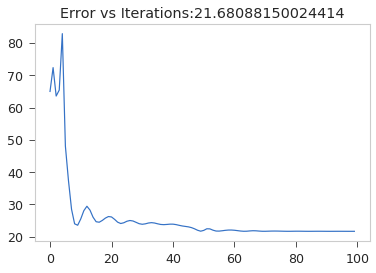

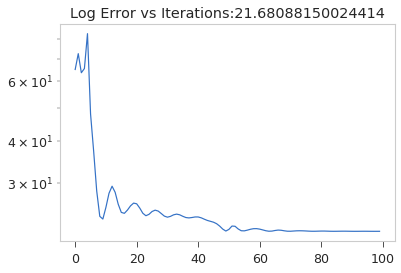

In [93]:
n_trials = 100
losses = np.zeros(n_trials)
for i in tqdm.tqdm(range(n_trials)):
    
    X_hat = net(X_tensor)
    cur_loss = loss(X_tensor, X_hat) 
    
    optimizer.zero_grad()
    cur_loss.backward()
    optimizer.step()
    
    losses[i] = cur_loss.item()

plt.plot(losses)
plt.title('Error vs Iterations:{}'.format(np.min(losses)))
plt.show()

plt.semilogy(losses)
plt.title('Log Error vs Iterations:{}'.format(np.min(losses)))
plt.show()

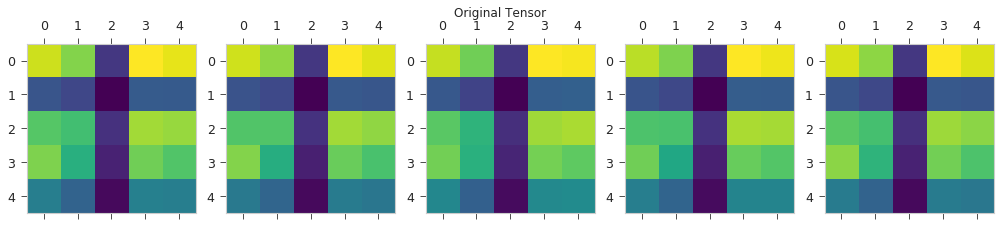

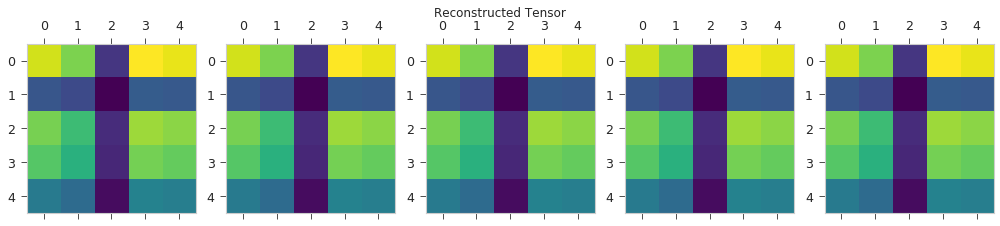

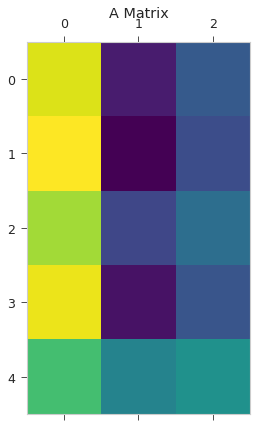

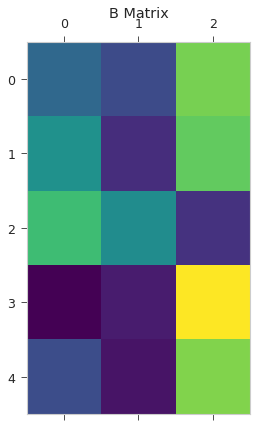

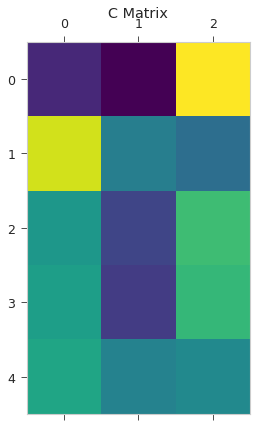

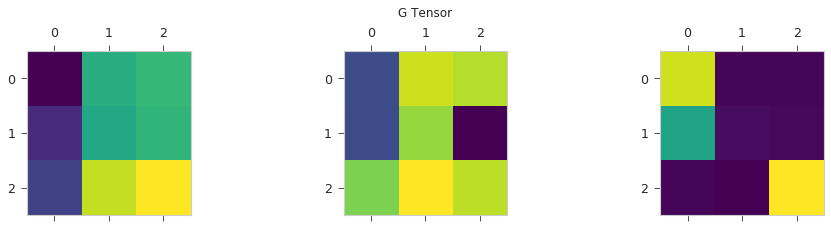

In [94]:
fig, ax = plt.subplots(1, I, figsize=(14, 3))
for i in range(I):
    ax[i].matshow(X[i].reshape((J, K)))
plt.suptitle('Original Tensor', y=1.04)
plt.tight_layout()
plt.show()


X_recon = net(X_tensor).detach().numpy().reshape((I, J, K))
A = net.get_A(X_tensor).detach().numpy()
B, C, G = net.get_BCG()

fig, ax = plt.subplots(1, I, figsize=(14, 3))
for i in range(I):
    ax[i].matshow(X_recon[i])
plt.suptitle('Reconstructed Tensor', y=1.04)
plt.tight_layout()
plt.show()

plt.matshow(A)
plt.title('A Matrix')
plt.show()

plt.matshow(B)
plt.title('B Matrix')
plt.show()

plt.matshow(C)
plt.title('C Matrix')
plt.show()

G_tensor = G.reshape((D, E, F))
fig, ax = plt.subplots(1, D, figsize=(14, 3))
for d in range(D):
    ax[d].matshow(G_tensor[d])
plt.suptitle('G Tensor', y=1.04)
plt.tight_layout()
plt.show()

## Autoencoder Tucker Celeba

In [105]:
celeba_dir = './data/mini_celeba'
fnames = glob2.glob(celeba_dir + '/*.jpg')
imgs = [io.imread(fname, as_gray=True) for fname in fnames]
X = np.array(imgs)
I, J, K = X.shape


net = AutoEncoderTucker((I,J,K), (I,J,K))
optimizer = torch.optim.Adam(net.parameters(), lr=6e-3)
X_tensor = torch.FloatTensor(X).view(X.shape[0], -1)


def loss(x, x_hat):
    return ((x - x_hat)**2).sum()

net.train()

AutoEncoderTucker(
  (sm): Softmax(dim=-1)
  (relu): ReLU()
)

100%|██████████| 5000/5000 [25:53<00:00,  3.22it/s]


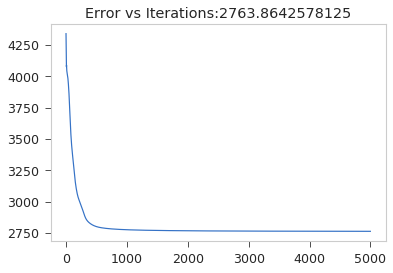

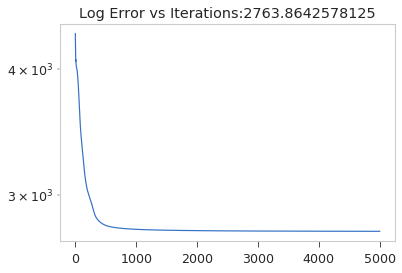

In [106]:
n_trials = 5000
losses = np.zeros(n_trials)
for i in tqdm.tqdm(range(n_trials)):
    
    X_hat = net(X_tensor)
    cur_loss = loss(X_tensor, X_hat) 
    
    optimizer.zero_grad()
    cur_loss.backward()
    optimizer.step()
    
    losses[i] = cur_loss.item()

plt.plot(losses)
plt.title('Error vs Iterations:{}'.format(np.min(losses)))
plt.show()

plt.semilogy(losses)
plt.title('Log Error vs Iterations:{}'.format(np.min(losses)))
plt.show()

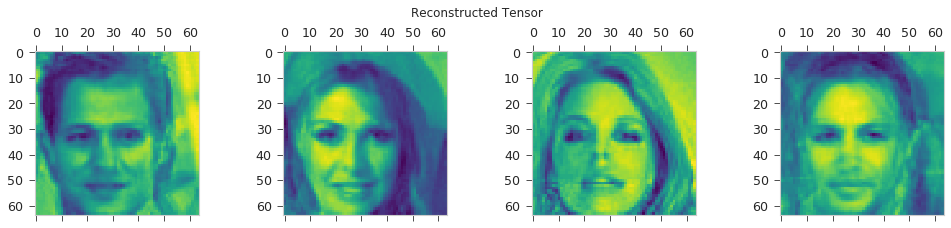

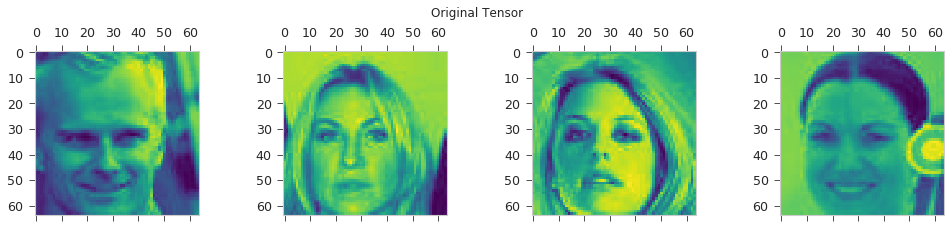

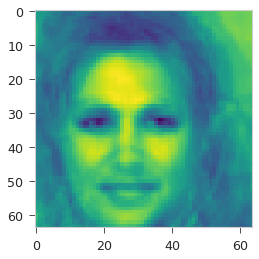

In [107]:
to_plot = 4

X_recon = net(X_tensor).detach().numpy().reshape((I, J, K))
fig, ax = plt.subplots(1, to_plot, figsize=(14, 3))
for i in range(to_plot):
    ax[i].matshow(X_recon[i])
plt.suptitle('Reconstructed Tensor', y=1.04)
plt.tight_layout()
plt.show()

X_plot = X.reshape((I, J, K))
fig, ax = plt.subplots(1, to_plot, figsize=(14, 3))
for i in range(to_plot):
    ax[i].matshow(X_plot[i])
plt.suptitle('Original Tensor', y=1.04)
plt.tight_layout()
plt.show()

plt.imshow(X_plot.mean(0))
plt.show()